In [1]:
 !pip install ray[rllib] pandas openpyxl


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import ray
print("Ray version:", ray.__version__)

Ray version: 2.44.1


In [3]:

import ray
from ray import tune
from ray.rllib.algorithms.ppo import PPO as PPOTrainer
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from gymnasium import spaces
import numpy as np
import random
import pandas as pd

# Load dataset
df = pd.read_excel("network_data.xlsx")
df.head()


,Latency,Packet_Loss,Throughput
0,9.472161,0.000000,0.409477
1,9.472161,0.000000,0.021766
2,9.472161,0.000000,2.419578
3,9.472161,0.000802,3.012930
4,9.472161,0.000600,4.907984


In [4]:
class SimulatedLogEnv(MultiAgentEnv):
    def __init__(self, config):
        self.data = config["logs"].reset_index(drop=True)
        self.index = 0
        self.max_steps = len(self.data)
        
        # Each observation = [Latency, Packet_Loss, Throughput]
        self.observation_space = spaces.Dict({
            "optimization_agent": spaces.Box(low=0, high=1000, shape=(3,), dtype=np.float32)
        })
        self.action_space = spaces.Dict({
            "optimization_agent": spaces.Discrete(3)  # 0 = do nothing, 1 = optimize latency, 2 = optimize throughput
        })
        self._agent_ids = {"optimization_agent"}

    def reset(self, *, seed=None, options=None):
        self.index = 0
        row = self.data.iloc[self.index]

        obs = {
            "optimization_agent": np.array([
                float(row["Latency"]),
                float(row["Packet_Loss"]),
                float(row["Throughput"])
            ], dtype=np.float32)
        }
        info = {"optimization_agent": {}}
        return obs, info

    def step(self, action_dict):
        self.index += 1
        
        # Handle end of episode
        if self.index >= self.max_steps:
            obs = {"optimization_agent": np.zeros(3, dtype=np.float32)}
            rewards = {"optimization_agent": 0}
            terminateds = {"optimization_agent": True, "__all__": True}
            truncateds = {"optimization_agent": False, "__all__": False}
            infos = {"optimization_agent": {}}
            return obs, rewards, terminateds, truncateds, infos  # Return 5 values as expected
        
        row = self.data.iloc[self.index]
        obs_vector = np.array([
            float(row["Latency"]),
            float(row["Packet_Loss"]),
            float(row["Throughput"])
        ], dtype=np.float32)

        # Initialize dictionaries
        obs = {}
        rewards = {}
        terminateds = {}  # Was previously "dones"
        truncateds = {}   # New in Gymnasium API
        infos = {}

        for agent_id, action in action_dict.items():
            # Reward = high throughput - penalty for latency and packet loss
            reward = row["Throughput"] - (0.1 * row["Latency"] + 100 * row["Packet_Loss"])
            
            obs[agent_id] = obs_vector
            rewards[agent_id] = reward
            terminateds[agent_id] = False
            truncateds[agent_id] = False  # Add truncated flag
            infos[agent_id] = {}

        terminateds["__all__"] = False
        truncateds["__all__"] = False  # Add truncated flag for all agents
        
        return obs, rewards, terminateds, truncateds, infos  # Return 5 values

In [5]:

@ray.remote
class MonitoringAgent:
    def __init__(self, dataframe):
        self.logs = dataframe

    def get_logs(self):
        return self.logs

@ray.remote
class AnomalyDetectionAgent:
    def detect_anomalies(self, df):
        latency_anomalies = df[df["Latency"] >= 0.5]
        throughput_anomalies = df[(df["Throughput"] < 10) | (df["Throughput"] > 100)]
        packet_loss_anomalies = df[(df["Packet_Loss"] < 0.1) | (df["Packet_Loss"] > 0.5)]
        return {
            "Latency Anomalies": latency_anomalies,
            "Throughput Anomalies": throughput_anomalies,
            "Packet Loss Anomalies": packet_loss_anomalies
        }


In [13]:
def run_optimization_agent(log_df):
    ray.init(ignore_reinit_error=True)

    # Register the environment with proper argument handling
    def env_creator(env_config):
        return SimulatedLogEnv(env_config)
    
    tune.register_env("log_env", env_creator)
    
    # Define a flexible policy mapping function
    def policy_mapping_fn(agent_id, *args, **kwargs):
        return "optimization_agent"
    
    config = {
        "env": "log_env",
        "env_config": {"logs": log_df},
        "framework": "torch",
        "num_workers": 0,
        "multiagent": {
            "policies": {
                "optimization_agent": (
                    None,  # Policy class (None uses default)
                    spaces.Box(low=0, high=1000, shape=(3,), dtype=np.float32),  # Observation space
                    spaces.Discrete(3),  # Action space
                    {}  # Extra config
                ),
            },
            "policy_mapping_fn": policy_mapping_fn,
        },
        "disable_env_checking": True,
        "use_new_env_runners": True
    }

    trainer = PPOTrainer(config=config)

    for i in range(5):
        result = trainer.train()
        
        # Access the reward metrics from env_runners
        if "env_runners" in result and "episode_return_mean" in result["env_runners"]:
            mean_reward = result["env_runners"]["episode_return_mean"]
            min_reward = result["env_runners"]["episode_return_min"]
            max_reward = result["env_runners"]["episode_return_max"]
            episodes = result["env_runners"].get("num_episodes", 0)
            
            print(f"Iteration {i}: episodes={episodes}, "
                  f"mean_reward={mean_reward:.3f}, "
                  f"min_reward={min_reward:.3f}, "
                  f"max_reward={max_reward:.3f}")
        else:
            print(f"Iteration {i} complete - no reward metrics available")

    ray.shutdown()

In [14]:

ray.init(ignore_reinit_error=True)

monitor = MonitoringAgent.remote(df)
logs = ray.get(monitor.get_logs.remote())

detector = AnomalyDetectionAgent.remote()
anomalies = ray.get(detector.detect_anomalies.remote(logs))
for key, value in anomalies.items():
    print(f"\n{key} Detected ({len(value)} entries):\n{value}")

run_optimization_agent(logs)
ray.shutdown()


2025-04-15 01:30:16,872	INFO worker.py:1852 -- Started a local Ray instance.



Latency Anomalies Detected (1495 entries):
        Latency  Packet_Loss   Throughput
0      9.472161     0.000000     0.409477
1      9.472161     0.000000     0.021766
2      9.472161     0.000000     2.419578
3      9.472161     0.000802     3.012930
4      9.472161     0.000600     4.907984
...         ...          ...          ...
1490   5.607309     0.000008  2509.464844
1491  26.551856     0.000008  2511.058727
1492   5.572681     0.000008  2512.285750
1493   8.103335     0.000008  2514.069445
1494  15.975479     0.000008  2515.605859

[1495 rows x 3 columns]

Throughput Anomalies Detected (1491 entries):
        Latency  Packet_Loss   Throughput
0      9.472161     0.000000     0.409477
1      9.472161     0.000000     0.021766
2      9.472161     0.000000     2.419578
3      9.472161     0.000802     3.012930
4      9.472161     0.000600     4.907984
...         ...          ...          ...
1490   5.607309     0.000008  2509.464844
1491  26.551856     0.000008  2511.058727
14

2025-04-15 01:30:24,558	INFO worker.py:1684 -- Calling ray.init() again after it has already been called.
C:\Users\anyak\myenv\Lib\site-packages\ray\rllib\algorithms\algorithm.py:512: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
C:\Users\anyak\myenv\Lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
C:\Users\anyak\myenv\Lib\site-packages\ray\tune\logger\unified.py:53: Ra

Iteration 0: episodes=2, mean_reward=1932045.665, min_reward=1932045.665, max_reward=1932045.665
Iteration 1: episodes=3, mean_reward=1932045.665, min_reward=1932045.665, max_reward=1932045.665
Iteration 2: episodes=3, mean_reward=1932045.665, min_reward=1932045.665, max_reward=1932045.665
Iteration 3: episodes=2, mean_reward=1932045.665, min_reward=1932045.665, max_reward=1932045.665
Iteration 4: episodes=3, mean_reward=1932045.665, min_reward=1932045.665, max_reward=1932045.665


In [15]:
env = SimulatedLogEnv({"logs": df})
obs, _ = env.reset()
print("Observation:", obs["optimization_agent"])
print("Shape:", obs["optimization_agent"].shape)


Observation: [9.472161   0.         0.40947655]
Shape: (3,)


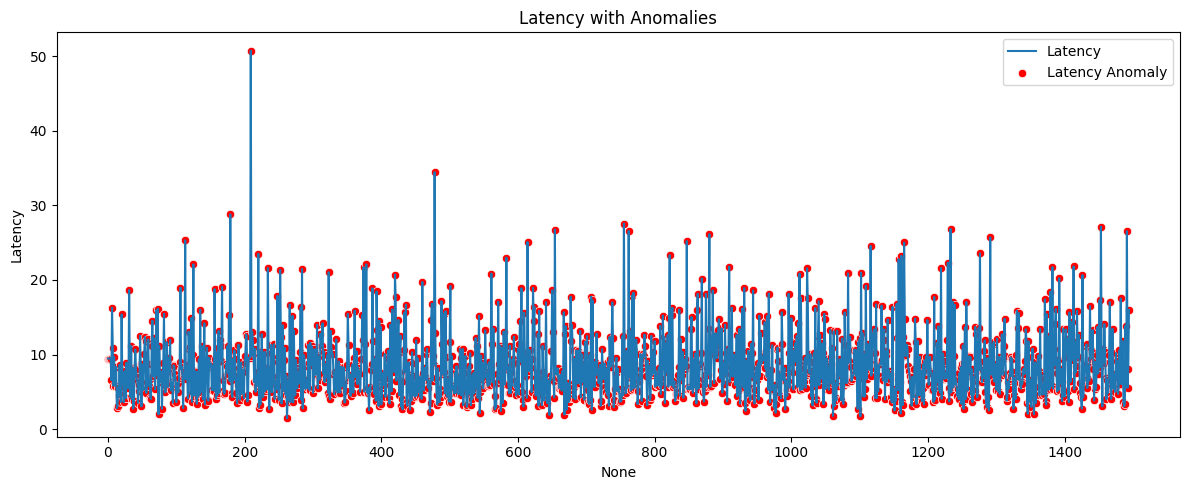

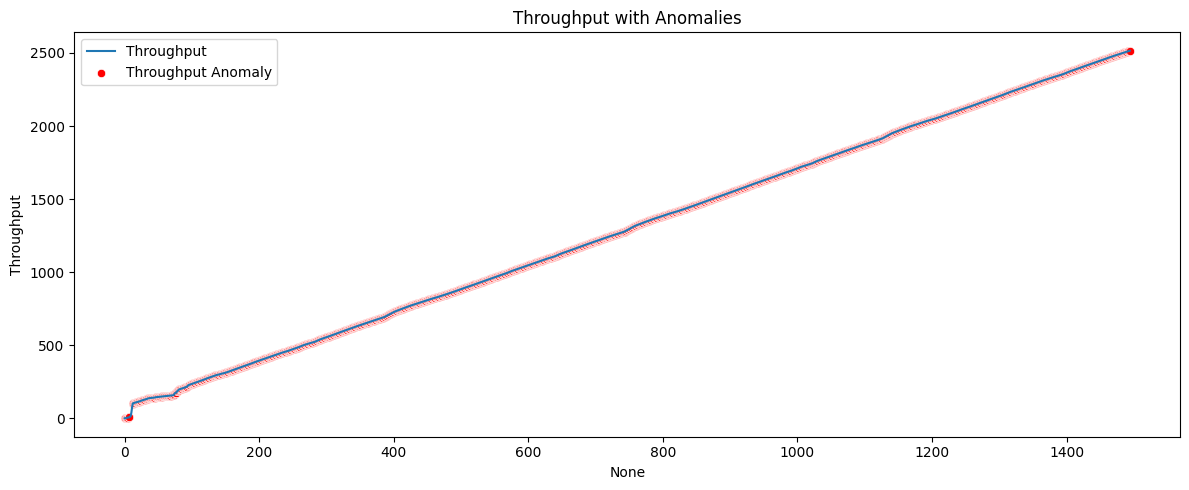

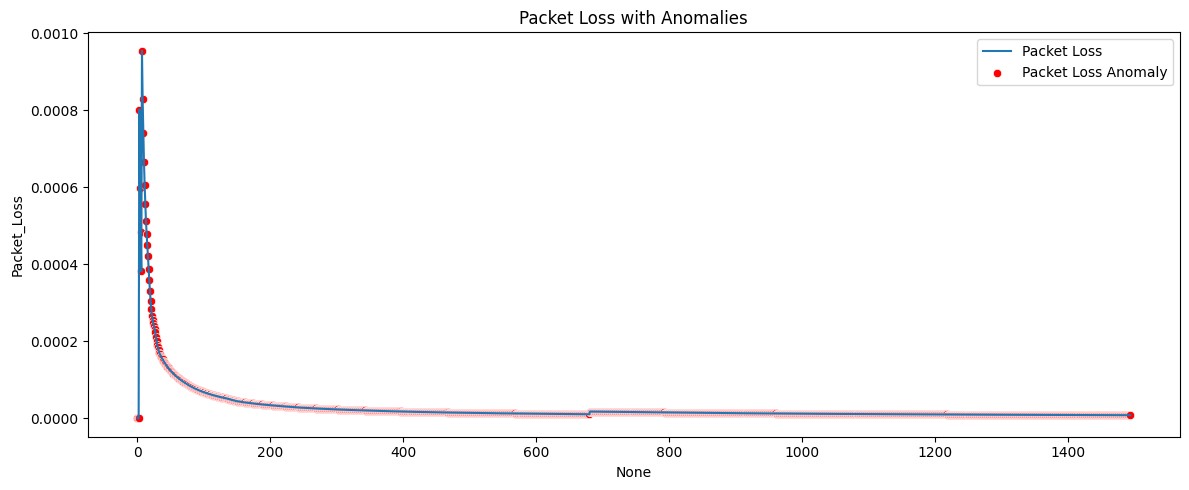

In [17]:
# Required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_excel("network_data.xlsx")  # Make sure the file is in the same directory

# Define thresholds
latency_threshold = 0.5
throughput_low = 10
throughput_high = 100
packet_loss_low = 0.1
packet_loss_high = 0.5

# Detect anomalies
df['Latency_Anomaly'] = df['Latency'] >= latency_threshold
df['Throughput_Anomaly'] = (df['Throughput'] < throughput_low) | (df['Throughput'] > throughput_high)
df['PacketLoss_Anomaly'] = (df['Packet_Loss'] < packet_loss_low) | (df['Packet_Loss'] > packet_loss_high)

# Compute severity score
df['Severity_Score'] = (
    (df['Latency'] / df['Latency'].max()) * df['Latency_Anomaly'].astype(int) +
    (abs(df['Throughput'] - 55) / 55) * df['Throughput_Anomaly'].astype(int) +
    (df['Packet_Loss'] / df['Packet_Loss'].max()) * df['PacketLoss_Anomaly'].astype(int)
) / 3

# Categorize severity level
def categorize_severity(score):
    if score > 0.6:
        return 'High'
    elif score > 0.3:
        return 'Medium'
    elif score > 0:
        return 'Low'
    return 'None'

df['Severity_Level'] = df['Severity_Score'].apply(categorize_severity)

# --- Visualization Section ---
plt.figure(figsize=(12, 5))
sns.lineplot(data=df['Latency'], label='Latency')
sns.scatterplot(x=df[df['Latency_Anomaly']].index, y=df[df['Latency_Anomaly']]['Latency'], color='red', label='Latency Anomaly')
plt.title("Latency with Anomalies")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=df['Throughput'], label='Throughput')
sns.scatterplot(x=df[df['Throughput_Anomaly']].index, y=df[df['Throughput_Anomaly']]['Throughput'], color='red', label='Throughput Anomaly')
plt.title("Throughput with Anomalies")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=df['Packet_Loss'], label='Packet Loss')
sns.scatterplot(x=df[df['PacketLoss_Anomaly']].index, y=df[df['PacketLoss_Anomaly']]['Packet_Loss'], color='red', label='Packet Loss Anomaly')
plt.title("Packet Loss with Anomalies")
plt.legend()
plt.tight_layout()
plt.show()
